חלק 1: טעינת נתונים, חילוץ תוויות והצגה ראשונית 

--- Part 1: Data Loading & Initial Checks ---
Found 4 CSV files.

Total individual sensor recordings created: 4
Label encoding: [(np.str_('car'), 0), (np.str_('human'), 1), (np.str_('nothing'), 2)]


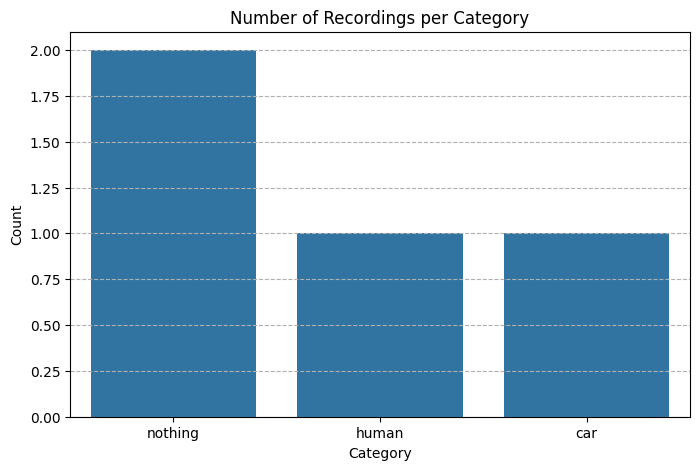

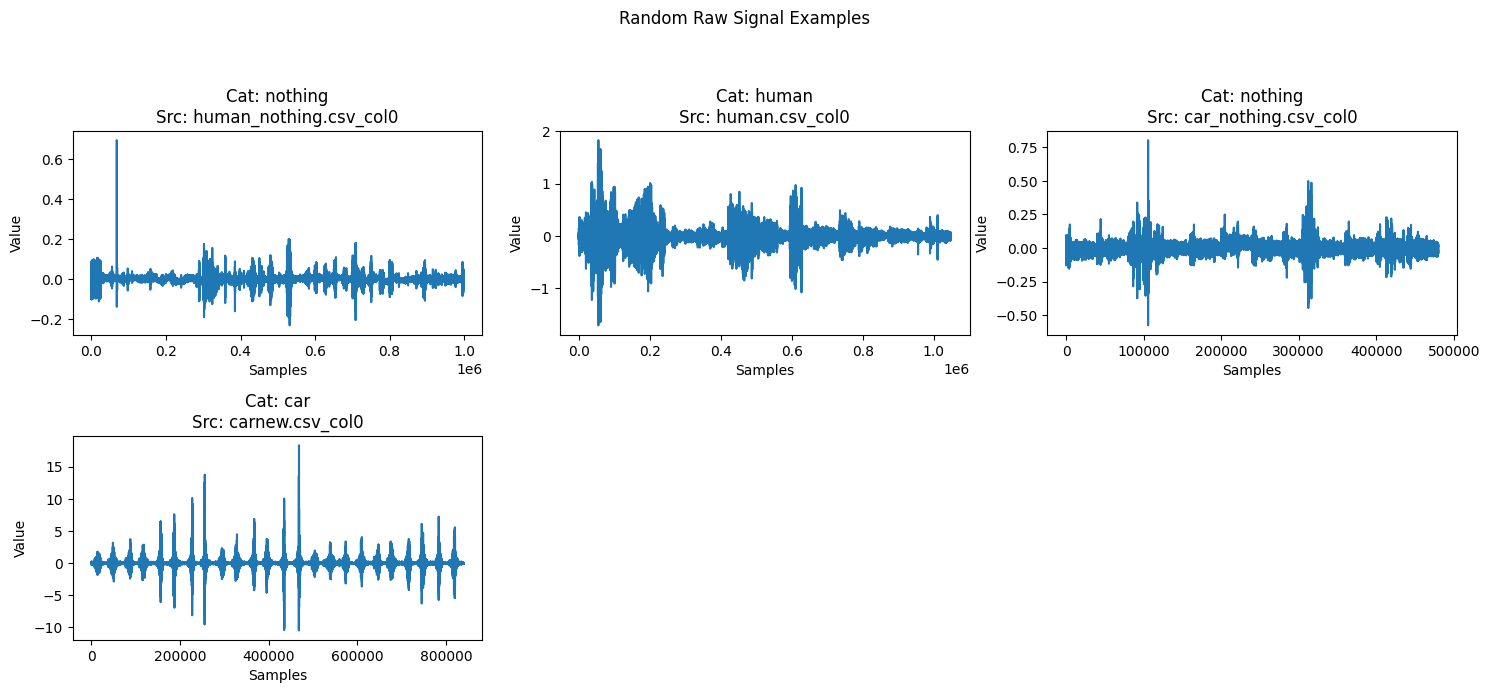

In [69]:
# Part 1: Load Data, Extract Labels, Initial Visualization
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random

print("--- Part 1: Data Loading & Initial Checks ---")

# --- Configuration ---
DATA_DIR = 'data'
CATEGORIES = ['nothing', 'human', 'car']
# --------------------

def get_label_from_filename(filename):
    filename_lower = filename.lower()
    if 'nothing' in filename_lower: return 'nothing'
    elif 'human' in filename_lower or 'man' in filename_lower: return 'human'
    elif 'car' in filename_lower: return 'car'
    else: return None

all_series = []
all_labels = []
source_info = []

csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
print(f"Found {len(csv_files)} CSV files.")

for filepath in csv_files:
    filename = os.path.basename(filepath)
    label = get_label_from_filename(filename)
    if label is None: continue

    try:
        df = pd.read_csv(filepath, header=None)
        for i, col_name in enumerate(df.columns):
            sensor_series = df[col_name].values
            all_series.append(sensor_series)
            all_labels.append(label)
            source_info.append(f"{filename}_col{i}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

print(f"\nTotal individual sensor recordings created: {len(all_series)}")

if all_series:
    # Encode labels to integers (0, 1, 2...)
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(all_labels)
    num_classes = len(label_encoder.classes_)
    print(f"Label encoding: {list(zip(label_encoder.classes_, range(num_classes)))}")

    # Plot category counts
    plt.figure(figsize=(8, 5))
    sns.countplot(x=all_labels, order=CATEGORIES)
    plt.title('Number of Recordings per Category')
    plt.ylabel('Count'); plt.xlabel('Category')
    plt.grid(axis='y', linestyle='--'); plt.show()

    # Plot random examples
    plt.figure(figsize=(15, 10))
    plt.suptitle('Random Raw Signal Examples')
    num_examples_to_show = min(9, len(all_series))
    random_indices = random.sample(range(len(all_series)), num_examples_to_show)
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.plot(all_series[idx])
        plt.title(f"Cat: {all_labels[idx]}\nSrc: {source_info[idx]}")
        plt.xlabel("Samples"); plt.ylabel("Value")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nNo data loaded, cannot proceed.")
    exit() # Exit if no data

חלק 2: עיבוד מקדים - חלוקה לחלונות, חלוקה לסטים ונרמול


--- Part 2: Preprocessing ---
Creating windows (size=2000, step=1000)...
Total windows created: 3362
Window data shape: (3362, 2000)
Train set size: 2428
Validation set size: 429
Test set size: 505
Performing standardization...
Standardization complete.
Scaler saved successfully to scaler.joblib


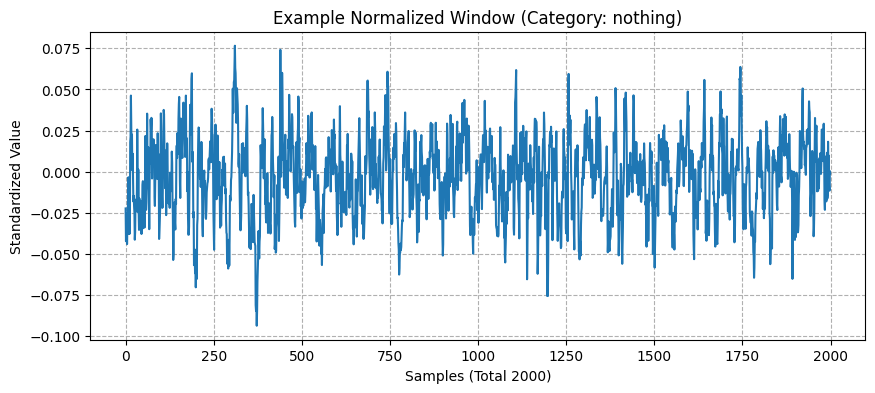

In [70]:
# Part 2: Preprocessing - Windowing, Splitting, Normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
print("\n--- Part 2: Preprocessing ---")

# --- Configuration ---
WINDOW_SIZE = 2000 # Samples per window $$$$WINDOWWWWWWWWWWWWWW
STEP = 1000        # Step between windows
# --------------------

def create_windows(series, window_size, step):
    windows = []
    for i in range(0, len(series) - window_size + 1, step):
        windows.append(series[i : i + window_size])
    return np.array(windows)

all_windows = []
all_window_labels = []

print(f"Creating windows (size={WINDOW_SIZE}, step={STEP})...")
for i in range(len(all_series)):
    series = all_series[i]
    label = encoded_labels[i] # Use integer labels
    if len(series) >= WINDOW_SIZE:
        windows = create_windows(series, WINDOW_SIZE, STEP)
        all_windows.extend(windows)
        all_window_labels.extend([label] * len(windows))

if not all_windows:
    print("Error: No windows were created.")
    exit()

X = np.array(all_windows)
y = np.array(all_window_labels) # Keep labels as integers (0, 1, 2...)
print(f"Total windows created: {len(X)}")
print(f"Window data shape: {X.shape}") # (num_windows, window_length)

# Split into Train, Validation, Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardization (Fit on Train only!)
scaler = StandardScaler()
# Reshape needed for scaler if scaling across features (time steps)
# Option 1: Scale each window independently (simpler, less common)
# Option 2: Scale based on overall train set statistics (standard)
print("Performing standardization...")
# Reshape to (num_samples, num_features=WINDOW_SIZE)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to (num_samples, window_length)
X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)
print("Standardization complete.")

# Keep integer labels: y_train, y_val, y_test


# ... אחרי השורה:
SCALER_SAVE_PATH = 'scaler.joblib'
try:
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Scaler saved successfully to {SCALER_SAVE_PATH}")
except Exception as e:
    print(f"Error saving scaler: {e}")
    
# Plot an example normalized window
plt.figure(figsize=(10, 4))
plt.plot(X_train_scaled[0])
plt.title(f'Example Normalized Window (Category: {label_encoder.classes_[y_train[0]]})')
plt.xlabel(f'Samples (Total {WINDOW_SIZE})')
plt.ylabel('Standardized Value')
plt.grid(True, linestyle='--'); plt.show()



חלק 3: הגדרת מודל PyTorch

In [71]:
# Part 3: PyTorch Model Definition
import torch
import torch.nn as nn
import torch.optim as optim

print("\n--- Part 3: PyTorch Model Definition ---")

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the 1D CNN Model
class Geophone1DCNN_PyTorch(nn.Module):
    def __init__(self, input_length, num_classes):
        super(Geophone1DCNN_PyTorch, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding='same'),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
            nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding='same'), # Reduced filters
            nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2)
        )
        flattened_size = 64 * (input_length // 8)
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 100), nn.ReLU(), nn.Dropout(0.6), # Reduced neurons, increased dropout
            nn.Linear(100, 50), nn.ReLU(), nn.Dropout(0.4),            # Reduced neurons, increased dropout
            nn.Linear(50, num_classes) # Output logits
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc_block(x)
        return x

# Instantiate the model
if 'WINDOW_SIZE' in locals() and 'num_classes' in locals():
    pytorch_model = Geophone1DCNN_PyTorch(input_length=WINDOW_SIZE, num_classes=num_classes).to(device)

    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pytorch_model.parameters(), lr=0.0005, weight_decay=1e-4) # Added weight decay

    # Print Model Summary (Optional: requires torchsummary)
    try:
        from torchsummary import summary
        summary(pytorch_model, (1, WINDOW_SIZE)) # Input shape: (channels, length)
    except ImportError:
        print("\nModel Structure:")
        print(pytorch_model)
    print("\nModel, Criterion, Optimizer defined.")
else:
    print("Error: WINDOW_SIZE or num_classes not defined.")
    exit()


--- Part 3: PyTorch Model Definition ---
Using device: cuda

Model Structure:
Geophone1DCNN_PyTorch(
  (conv_block1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=same)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(


חלק 4: Dataset, DataLoader, אימון והצגת גרפים



--- Part 4: Training Setup and Execution ---
Creating DataLoaders...
DataLoaders created.

Starting training (Max Epochs=50, Patience=10)...

Starting training loop for 50 epochs...


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | LR: 0.000500 | Tr Loss: 0.7965, Tr Acc: 0.6252 | Val Loss: 0.5422, Val Acc: 0.7646 | Time: 0.62s
Epoch 2/50 | LR: 0.000500 | Tr Loss: 0.6080, Tr Acc: 0.7488 | Val Loss: 0.4646, Val Acc: 0.8228 | Time: 0.62s
Epoch 3/50 | LR: 0.000500 | Tr Loss: 0.5605, Tr Acc: 0.7710 | Val Loss: 0.4120, Val Acc: 0.8205 | Time: 0.61s
Epoch 4/50 | LR: 0.000500 | Tr Loss: 0.4927, Tr Acc: 0.7978 | Val Loss: 0.3188, Val Acc: 0.8671 | Time: 0.60s
Epoch 5/50 | LR: 0.000500 | Tr Loss: 0.4593, Tr Acc: 0.8320 | Val Loss: 0.4120, Val Acc: 0.8298 | Time: 0.61s
Epoch 6/50 | LR: 0.000500 | Tr Loss: 0.4359, Tr Acc: 0.8229 | Val Loss: 0.3063, Val Acc: 0.8928 | Time: 0.62s
Epoch 7/50 | LR: 0.000500 | Tr Loss: 0.4143, Tr Acc: 0.8377 | Val Loss: 0.3274, Val Acc: 0.8671 | Time: 0.61s
Epoch 8/50 | LR: 0.000500 | Tr Loss: 0.3515, Tr Acc: 0.8624 | Val Loss: 0.2370, Val Acc: 0.9161 | Time: 0.60s
Epoch 9/50 | LR: 0.000500 | Tr Loss: 0.3431, Tr Acc: 0.8608 | Val Loss: 0.2162, Val Acc: 0.9254 | Time: 0.61s
Epoch 10/5

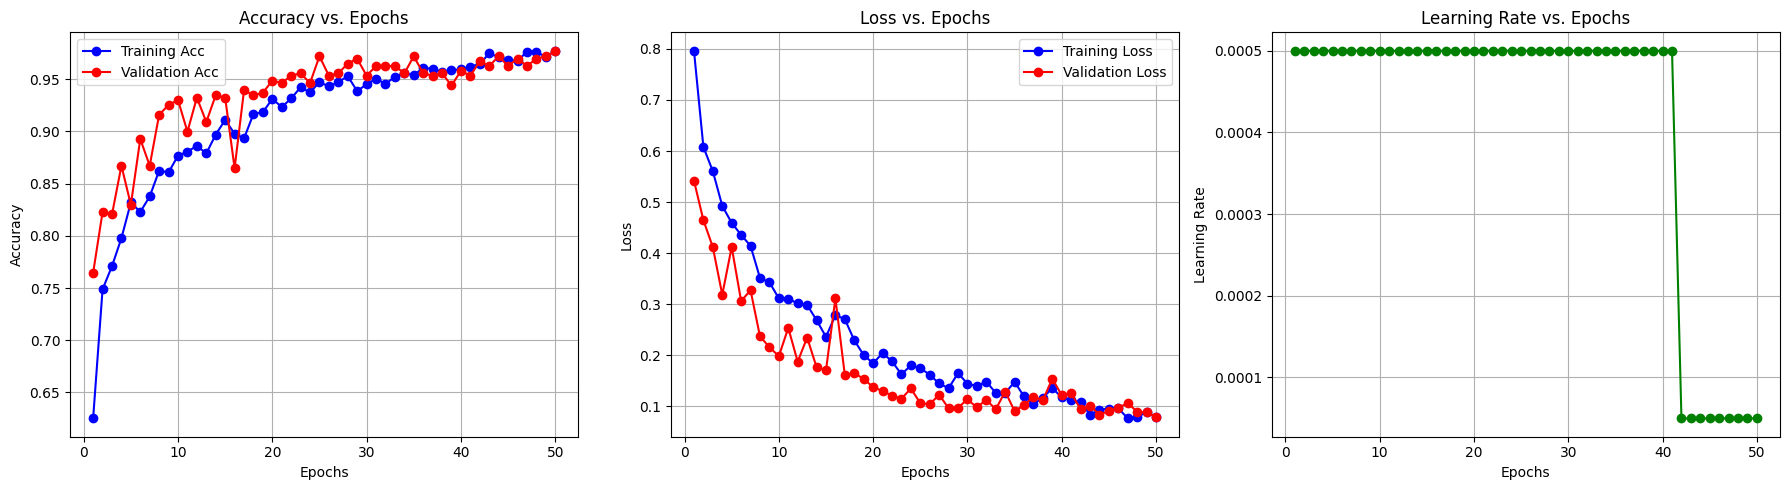

In [72]:
# Part 4: Dataset, Dataloader, Training Loop, History Plotting
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import time
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns # Needed if plotting confusion matrix in part 5 later

print("\n--- Part 4: Training Setup and Execution ---")

# --- Configuration ---
EPOCHS = 50
BATCH_SIZE = 64
PATIENCE = 10 # For Early Stopping
MODEL_SAVE_PATH = 'best_geophone_model_pytorch.pth'
# Augmentation Params
AUGMENT_PROB = 0.5
NOISE_LEVEL = 0.005
MAX_TIME_SHIFT = 10
# --------------------

# --- Augmented Dataset Definition ---
class GeophoneDatasetAugmented(Dataset):
    """ Custom PyTorch Dataset with optional augmentation """
    def __init__(self, features, labels, is_train=False):
        # Store features and labels as tensors
        # Add channel dimension for Conv1d: (N, C, L) -> (N, 1, WindowLength)
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        # Use Long type for labels for CrossEntropyLoss
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.is_train = is_train # Flag to enable/disable augmentation

    def __len__(self):
        # Return the total number of samples
        return len(self.labels)

    def __getitem__(self, idx):
        # Get a single sample
        feature = self.features[idx]
        label = self.labels[idx]

        # Apply augmentation only during training phase
        if self.is_train and random.random() < AUGMENT_PROB:
            aug_type = random.choice(['noise', 'shift', 'both'])

            # Apply Noise Augmentation
            if aug_type in ['noise', 'both']:
                noise = torch.randn_like(feature) * NOISE_LEVEL
                feature = feature + noise

            # Apply Time Shift Augmentation
            if aug_type in ['shift', 'both']:
                shift = random.randint(-MAX_TIME_SHIFT, MAX_TIME_SHIFT)
                if shift != 0:
                    # Efficiently roll the tensor along the time dimension
                    feature = torch.roll(feature, shifts=shift, dims=-1)
                    # Zero-pad the rolled part
                    if shift > 0: feature[:, :shift] = 0
                    else: feature[:, shift:] = 0 # Correct slicing for negative shift

        return feature, label

# --- Training Function (includes validation, early stopping, LR scheduling) ---
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, patience, model_save_path, device):
    """ Trains the model, performs validation, implements early stopping and LR scheduling. """
    # Learning Rate Scheduler: Reduces LR if validation loss plateaus
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_val_loss = float('inf') # Initialize best validation loss
    epochs_no_improve = 0        # Counter for early stopping
    best_model_wts = None        # Store best model weights
    # Dictionary to store training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    print(f"\nStarting training loop for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        start_time = time.time()

        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            # Move data to the appropriate device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Standard training steps
            optimizer.zero_grad()       # Zero gradients
            outputs = model(inputs)     # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()             # Backward pass (calculate gradients)
            optimizer.step()            # Update weights

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1) # Get predicted class index
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['lr'].append(optimizer.param_groups[0]['lr']) # Record current learning rate

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables dropout, etc.)
        running_val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad(): # Disable gradient calculations for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # --- Scheduler and Early Stopping ---
        # Adjust learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        epoch_duration = time.time() - start_time
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Tr Loss: {epoch_train_loss:.4f}, Tr Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | "
              f"Time: {epoch_duration:.2f}s")

        # Check for improvement and save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            # Save the best model state dictionary
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_save_path)
            # print(f"Val loss improved. Saving model to {model_save_path}") # Optional verbosity
        else:
            epochs_no_improve += 1
            # Check if patience limit is reached for early stopping
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break # Exit the training loop

    print("\nTraining finished.")
    # Load the best weights found during training before returning
    if best_model_wts:
        model.load_state_dict(best_model_wts)
        print(f"Loaded best model weights from epoch {epoch+1 - epochs_no_improve}.")

    return model, history

# --- Main Execution Block (Important for multiprocessing on Windows) ---
if __name__ == '__main__':

    # --- Create Datasets and DataLoaders ---
    # Ensure the necessary data variables (X_train_scaled, y_train, etc.) exist from Part 2
    if 'X_train_scaled' in locals() and 'y_train' in locals() and \
       'X_val_scaled' in locals() and 'y_val' in locals() and \
       'X_test_scaled' in locals() and 'y_test' in locals():

        train_dataset = GeophoneDatasetAugmented(X_train_scaled, y_train, is_train=True)
        val_dataset = GeophoneDatasetAugmented(X_val_scaled, y_val, is_train=False)
        test_dataset = GeophoneDatasetAugmented(X_test_scaled, y_test, is_train=False)

        print("Creating DataLoaders...")
        # *** CRITICAL FIX: Set num_workers=0 to avoid multiprocessing issues, especially on Windows ***
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        # Create test_loader here as it's needed for Part 5 evaluation
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0)

        print("DataLoaders created.")
    else:
        print("Error: Scaled data not found. Cannot create DataLoaders or proceed with training.")
        exit() # Stop execution if data is missing

    # --- Run Training ---
    # Ensure the model, criterion, and optimizer exist from Part 3
    if 'pytorch_model' in locals() and 'criterion' in locals() and 'optimizer' in locals():
        print(f"\nStarting training (Max Epochs={EPOCHS}, Patience={PATIENCE})...")
        # Call the training function
        trained_pytorch_model, training_history = train_model(
            pytorch_model, criterion, optimizer, train_loader, val_loader,
            num_epochs=EPOCHS, patience=PATIENCE, model_save_path=MODEL_SAVE_PATH, device=device
        )

        # --- Plot Training History ---
        if training_history:
            epochs_ran = len(training_history['train_acc'])
            epochs_range = range(1, epochs_ran + 1)
            plt.figure(figsize=(18, 5))

            # Accuracy Plot
            plt.subplot(1, 3, 1)
            plt.plot(epochs_range, training_history['train_acc'], 'bo-', label='Training Acc')
            plt.plot(epochs_range, training_history['val_acc'], 'ro-', label='Validation Acc')
            plt.title('Accuracy vs. Epochs')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy')
            plt.legend(); plt.grid(True)

            # Loss Plot
            plt.subplot(1, 3, 2)
            plt.plot(epochs_range, training_history['train_loss'], 'bo-', label='Training Loss')
            plt.plot(epochs_range, training_history['val_loss'], 'ro-', label='Validation Loss')
            plt.title('Loss vs. Epochs')
            plt.xlabel('Epochs'); plt.ylabel('Loss')
            plt.legend(); plt.grid(True)

            # Learning Rate Plot
            plt.subplot(1, 3, 3)
            plt.plot(epochs_range, training_history['lr'], 'go-')
            plt.title('Learning Rate vs. Epochs')
            plt.xlabel('Epochs'); plt.ylabel('Learning Rate')
            plt.grid(True)

            plt.tight_layout(); plt.show()

    else:
        print("Error: Cannot start training. Model, Criterion or Optimizer missing.")


חלק 5: הערכה סופית על סט המבחן



--- Part 5: Final Evaluation ---
Evaluating on test set...

Test Loss: 0.0898
Test Accuracy: 0.9683 (96.83%)

Classification Report:
              precision    recall  f1-score   support

         car     0.9758    0.9603    0.9680       126
       human     0.9745    0.9745    0.9745       157
     nothing     0.9598    0.9685    0.9641       222

    accuracy                         0.9683       505
   macro avg     0.9701    0.9678    0.9689       505
weighted avg     0.9684    0.9683    0.9683       505


Confusion Matrix:


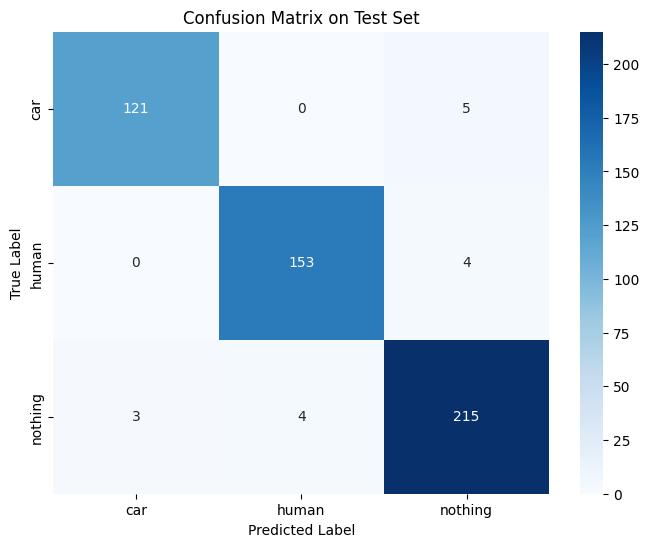

In [73]:
# Part 5: Final Evaluation on Test Set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns # For confusion matrix heatmap

print("\n--- Part 5: Final Evaluation ---")

# --- Evaluation Function ---
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    final_loss = running_loss / len(loader.dataset)
    final_accuracy = accuracy_score(all_labels, all_preds)
    return final_loss, final_accuracy, np.array(all_labels), np.array(all_preds)

# --- Run Evaluation on Test Set ---
if 'trained_pytorch_model' in locals() and 'test_loader' in locals():
    print("Evaluating on test set...")
    # Use the model returned from training (which should have best weights loaded)
    test_loss, test_accuracy, y_true_test, y_pred_test = evaluate_model(
        trained_pytorch_model, test_loader, criterion, device
    )

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # --- Display Results ---
    if 'label_encoder' in locals():
        class_names = label_encoder.classes_
        print("\nClassification Report:")
        print(classification_report(y_true_test, y_pred_test, target_names=class_names.tolist(), digits=4))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_true_test, y_pred_test)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        plt.title('Confusion Matrix on Test Set'); plt.show()
    else:
        print("Warning: LabelEncoder not found. Cannot display class names in report/matrix.")
        print("\nClassification Report (no names):")
        print(classification_report(y_true_test, y_pred_test, digits=4))
        print("\nConfusion Matrix (no names):")
        print(confusion_matrix(y_true_test, y_pred_test))
else:
    print("Error: Cannot evaluate. Trained model or test loader missing.")


--- Part 6: Evaluating on External DATATEST ---
Starting evaluation using external data from: DATATEST

Step 1: Loading Prerequisites...
  Using device: cuda
  Successfully loaded scaler from scaler.joblib
  Using label mapping for DATATEST folders: {'car': 0, 'man': 1, 'other': 2}
  Successfully loaded trained model weights from best_geophone_model_pytorch.pth
Step 1 completed successfully.

Step 2: Loading and processing data from 'DATATEST'...
  Processing folder: 'car' (Target Label: 0)
    Processed 2 files, created 528 windows.
  Processing folder: 'man' (Target Label: 1)
    Processed 1 files, created 1320 windows.
  Processing folder: 'other' (Target Label: 2)
    Processed 1 files, created 1000 windows.
  Successfully loaded and windowed 2848 total samples.
Step 2 completed successfully.

Step 3: Applying standardization...
  Standardization complete.
Step 3 completed successfully.

Step 4: Creating DataLoader...
  Created DataLoader for DATATEST with 23 batches.
Step 4 compl

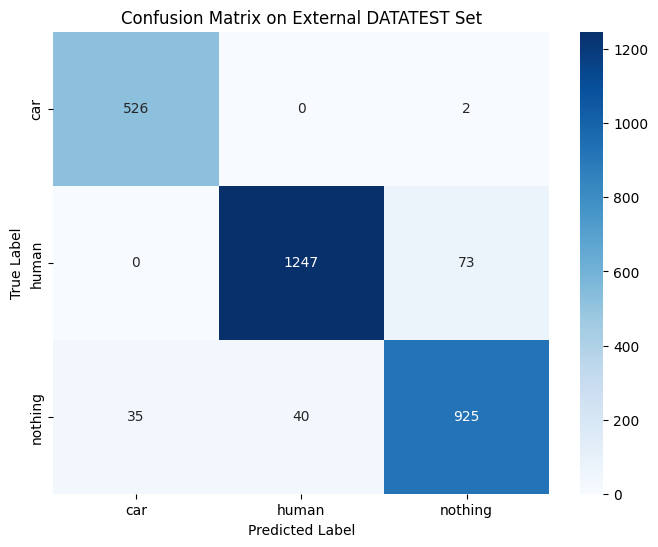

In [82]:
# Part 6: Evaluate Model on External DATATEST Dataset (Corrected v3 - Robust Checks)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import os
import glob
import pandas as pd
import numpy as np
import joblib # To load the scaler
import time
import copy
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Part 6: Evaluating on External DATATEST ---")

# --- Configuration (MUST match training settings) ---
DATATEST_DIR = 'DATATEST'
MODEL_SAVE_PATH = 'best_geophone_model_pytorch.pth'
SCALER_SAVE_PATH = 'scaler.joblib'
WINDOW_SIZE = 2000 #$$$$$$$$$$$$$$$$$$$$WINDOWW
STEP = 1000
BATCH_SIZE = 128
ORIGINAL_CATEGORIES = ['car', 'human', 'nothing'] # Verify this order!
NUM_CLASSES = len(ORIGINAL_CATEGORIES)
# ----------------------------------------------------

# --- Define Necessary Classes/Functions (Copied for self-containment) ---

# 1. Model Class Definition
class Geophone1DCNN_PyTorch(nn.Module):
    def __init__(self, input_length, num_classes):
        super(Geophone1DCNN_PyTorch, self).__init__()
        self.conv_block1=nn.Sequential(nn.Conv1d(1,32,5,padding='same'),nn.BatchNorm1d(32),nn.ReLU(),nn.MaxPool1d(2,2))
        self.conv_block2=nn.Sequential(nn.Conv1d(32,64,5,padding='same'),nn.BatchNorm1d(64),nn.ReLU(),nn.MaxPool1d(2,2))
        self.conv_block3=nn.Sequential(nn.Conv1d(64,64,5,padding='same'),nn.BatchNorm1d(64),nn.ReLU(),nn.MaxPool1d(2,2))
        flattened_size = 64*(input_length//8)
        self.fc_block=nn.Sequential(nn.Flatten(),nn.Linear(flattened_size,100),nn.ReLU(),nn.Dropout(0.6),
                           nn.Linear(100,50),nn.ReLU(),nn.Dropout(0.4),nn.Linear(50,num_classes))
    def forward(self,x):
        x=self.conv_block1(x); x=self.conv_block2(x); x=self.conv_block3(x); x=self.fc_block(x)
        return x

# 2. Dataset Class Definition
class GeophoneEvalDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]

# 3. Windowing Function
def create_windows(series, window_size, step):
    windows = []
    if len(series) >= window_size:
        for i in range(0, len(series) - window_size + 1, step): windows.append(series[i : i + window_size])
    return np.array(windows)

# 4. Evaluation Function
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    if not loader or not loader.dataset or len(loader.dataset) == 0:
        print("Error inside evaluate_model: Invalid or empty loader.")
        return 0.0, 0.0, np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels); running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    final_loss = running_loss / len(loader.dataset)
    final_accuracy = accuracy_score(all_labels, all_preds)
    return final_loss, final_accuracy, np.array(all_labels), np.array(all_preds)

# --- Main Execution Block for Evaluation ---
if __name__ == '__main__':

    print(f"Starting evaluation using external data from: {DATATEST_DIR}")

    # --- Initialize all necessary variables to None ---
    device = None
    scaler = None
    model_to_test = None
    label_to_int = {}
    new_folder_to_int = {}
    X_new = None
    y_new_true = None
    X_new_scaled = None
    new_test_loader = None
    evaluation_successful = False # Flag to track success

    try:
        # --- 1. Load Prerequisites ---
        print("\nStep 1: Loading Prerequisites...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"  Using device: {device}")

        # Load Scaler
        if not os.path.exists(SCALER_SAVE_PATH): raise FileNotFoundError(f"Scaler file missing: {SCALER_SAVE_PATH}")
        scaler = joblib.load(SCALER_SAVE_PATH)
        print(f"  Successfully loaded scaler from {SCALER_SAVE_PATH}")

        # Define Label Mapping
        label_to_int = {label: i for i, label in enumerate(ORIGINAL_CATEGORIES)}
        new_folder_to_int = {
            'car': label_to_int.get('car', -1),
            'man': label_to_int.get('human', -1),
            'other': label_to_int.get('nothing', -1)
        }
        if -1 in new_folder_to_int.values(): raise ValueError(f"Could not map DATATEST folders to ORIGINAL_CATEGORIES: {ORIGINAL_CATEGORIES}")
        print(f"  Using label mapping for DATATEST folders: {new_folder_to_int}")

        # Load Model
        model_to_test = Geophone1DCNN_PyTorch(input_length=WINDOW_SIZE, num_classes=NUM_CLASSES).to(device)
        if not os.path.exists(MODEL_SAVE_PATH): raise FileNotFoundError(f"Model weights file missing: {MODEL_SAVE_PATH}")
        model_to_test.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        model_to_test.eval() # Set to evaluation mode!
        print(f"  Successfully loaded trained model weights from {MODEL_SAVE_PATH}")
        print("Step 1 completed successfully.")

        # --- 2. Load and Process New Data from DATATEST ---
        print(f"\nStep 2: Loading and processing data from '{DATATEST_DIR}'...")
        all_new_windows = []
        all_new_labels = []
        found_folders_count = 0

        for folder_name, target_label_int in new_folder_to_int.items():
            folder_path = os.path.join(DATATEST_DIR, folder_name)
            # ... (Rest of the data loading loop is likely okay, kept for completeness) ...
            if not os.path.isdir(folder_path):
                print(f"  Warning: Subfolder '{folder_name}' not found. Skipping.")
                continue
            found_folders_count += 1
            print(f"  Processing folder: '{folder_name}' (Target Label: {target_label_int})")
            csv_files_in_folder = glob.glob(os.path.join(folder_path, '*.csv'))
            if not csv_files_in_folder:
                print(f"    Warning: No CSV files found.")
                continue
            file_count_in_folder, window_count_in_folder = 0, 0
            for filepath in csv_files_in_folder:
                try:
                    df = pd.read_csv(filepath, header=None)
                    file_processed = False
                    for i, col_name in enumerate(df.columns):
                        sensor_series = df[col_name].values
                        windows = create_windows(sensor_series, WINDOW_SIZE, STEP)
                        if windows.size > 0:
                            all_new_windows.extend(windows)
                            all_new_labels.extend([target_label_int] * len(windows))
                            window_count_in_folder += len(windows)
                            file_processed = True
                    if file_processed: file_count_in_folder += 1
                except Exception as e:
                    print(f"    Error processing file {os.path.basename(filepath)}: {e}")
            print(f"    Processed {file_count_in_folder} files, created {window_count_in_folder} windows.")


        if found_folders_count == 0 or not all_new_windows:
            raise RuntimeError(f"No valid data or windows found/created in {DATATEST_DIR}.")

        X_new = np.array(all_new_windows)
        y_new_true = np.array(all_new_labels)
        print(f"  Successfully loaded and windowed {len(X_new)} total samples.")
        print("Step 2 completed successfully.")

        # --- 3. Preprocess New Data (Scaling) ---
        print("\nStep 3: Applying standardization...")
        if scaler is None: raise ValueError("Scaler was not loaded.")
        if X_new is None: raise ValueError("New data (X_new) was not loaded.")
        X_new_reshaped = X_new.reshape(X_new.shape[0], -1)
        X_new_scaled = scaler.transform(X_new_reshaped).reshape(X_new.shape)
        print("  Standardization complete.")
        print("Step 3 completed successfully.")

        # --- 4. Create DataLoader for New Data ---
        print("\nStep 4: Creating DataLoader...")
        if X_new_scaled is None: raise ValueError("Scaled data (X_new_scaled) is not available.")
        new_test_dataset = GeophoneEvalDataset(X_new_scaled, y_new_true)
        if len(new_test_dataset) == 0: raise ValueError("Created dataset is empty.")
        new_test_loader = DataLoader(new_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        print(f"  Created DataLoader for DATATEST with {len(new_test_loader)} batches.")
        print("Step 4 completed successfully.")

        # --- 5. Evaluate on New Data ---
        print("\nStep 5: Evaluating model on DATATEST...")
        if not new_test_loader: raise ValueError("DataLoader (new_test_loader) was not created.")
        if not model_to_test: raise ValueError("Model (model_to_test) was not loaded.")

        criterion = nn.CrossEntropyLoss()
        start_eval_time = time.time()
        # *** This is the critical call ***
        test_loss, test_accuracy, y_true_final, y_pred_final = evaluate_model(
            model_to_test, new_test_loader, criterion, device
        )
        eval_duration = time.time() - start_eval_time
        print(f"  Evaluation finished in {eval_duration:.2f}s")
        evaluation_successful = True # Mark evaluation as successful
        print("Step 5 completed successfully.")

    except Exception as e:
        # Catch any error during the setup or processing steps
        print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR during script execution: {e}")
        print(f"Failed before completing evaluation.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # Optionally exit here or let it proceed to display whatever results were obtained before error
        # exit()


    # --- 6. Display Results (Only if evaluation was successful) ---
    if evaluation_successful:
        print("\n--- Step 6: Displaying Evaluation Results ---")
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print("\nClassification Report:")
        print(classification_report(y_true_final, y_pred_final, target_names=ORIGINAL_CATEGORIES, digits=4))
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_true_final, y_pred_final)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ORIGINAL_CATEGORIES, yticklabels=ORIGINAL_CATEGORIES)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        plt.title('Confusion Matrix on External DATATEST Set'); plt.show()
    else:
        print("\nSkipping result display because evaluation did not complete successfully.")


else:
    print("This script needs to be run directly to execute the evaluation.")


--- Part 7: Dataset Comparison ---
Starting Dataset Comparison...
Using pre-loaded original data (all_series, all_labels).
Organized original data by category.
Loading raw data from: DATATEST
  Processing folder 'car' -> category 'car'
  Processing folder 'man' -> category 'human'
  Processing folder 'other' -> category 'nothing'
Raw data loading complete.

Data Loading Summary:
  Original Dataset:
    car: 1 signals
    human: 1 signals
    nothing: 2 signals
  New DATATEST Dataset:
    car: 24 signals
    human: 40 signals
    nothing: 40 signals

Comparison 1: Plotting Raw Signal Examples...


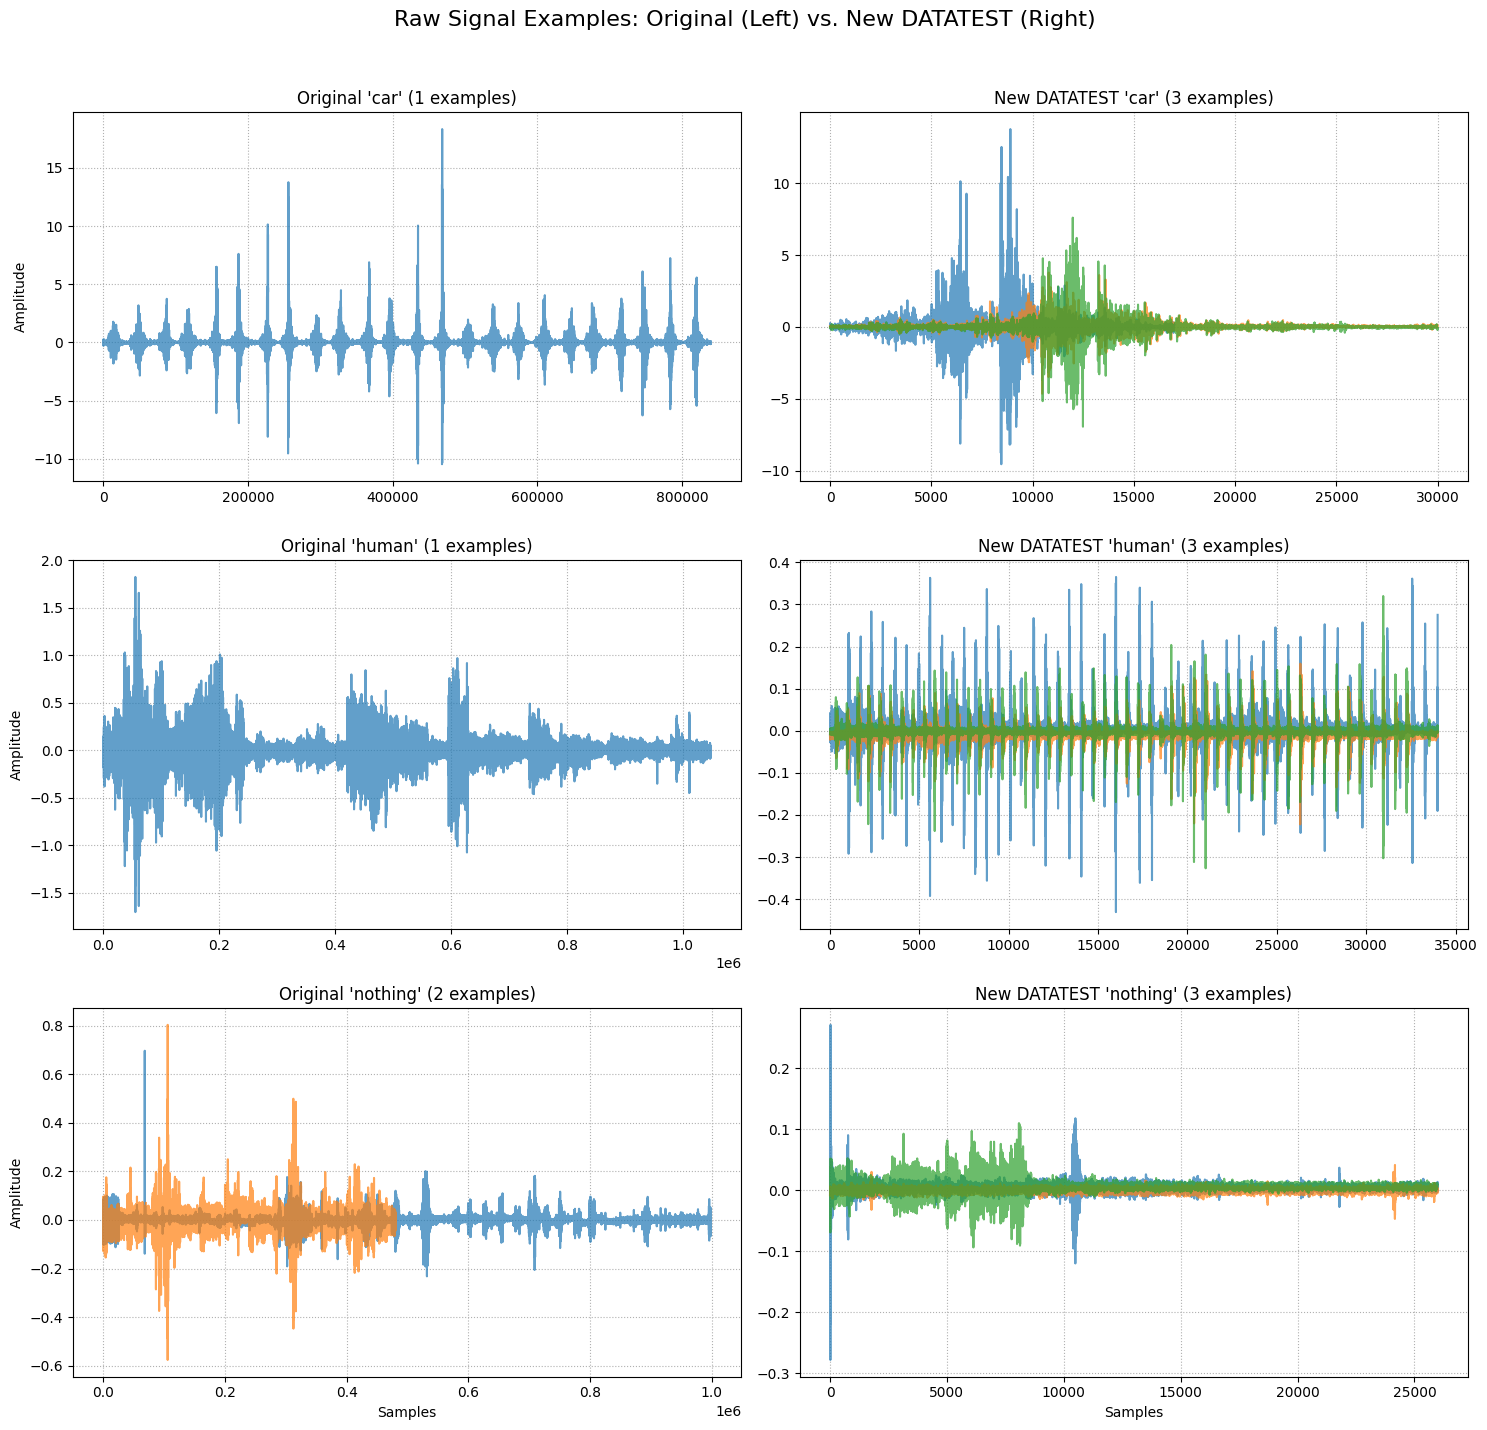


Comparison 2: Statistical Properties (Averages per Category)...
------------------------------------------------------------
Category   | Dataset    | Mean       | Std Dev    | RMS        | Min        | Max        | Skew       | Kurtosis   | Samples
------------------------------------------------------------
car        | Original   | -8.46e-04 | 4.01e-01 | 4.01e-01 | -1.05e+01 | 1.83e+01 | 1.14   | 104.70    | 1
car        | New Test   | -8.30e-04 | 5.90e-01 | 5.90e-01 | -5.05e+00 | 6.61e+00 | 0.45   | 19.90    | 24
------------------------------------------------------------
human      | Original   | 2.98e-04 | 5.16e-02 | 5.16e-02 | -1.70e+00 | 1.83e+00 | -0.18   | 84.40    | 1
human      | New Test   | -5.10e-05 | 4.19e-02 | 4.24e-02 | -4.78e-01 | 4.42e-01 | -0.45   | 17.74    | 40
------------------------------------------------------------
nothing    | Original   | -4.24e-04 | 2.17e-02 | 2.17e-02 | -4.04e-01 | 7.50e-01 | 0.20   | 15.01    | 2
nothing    | New Test   | -6.19e-05 |

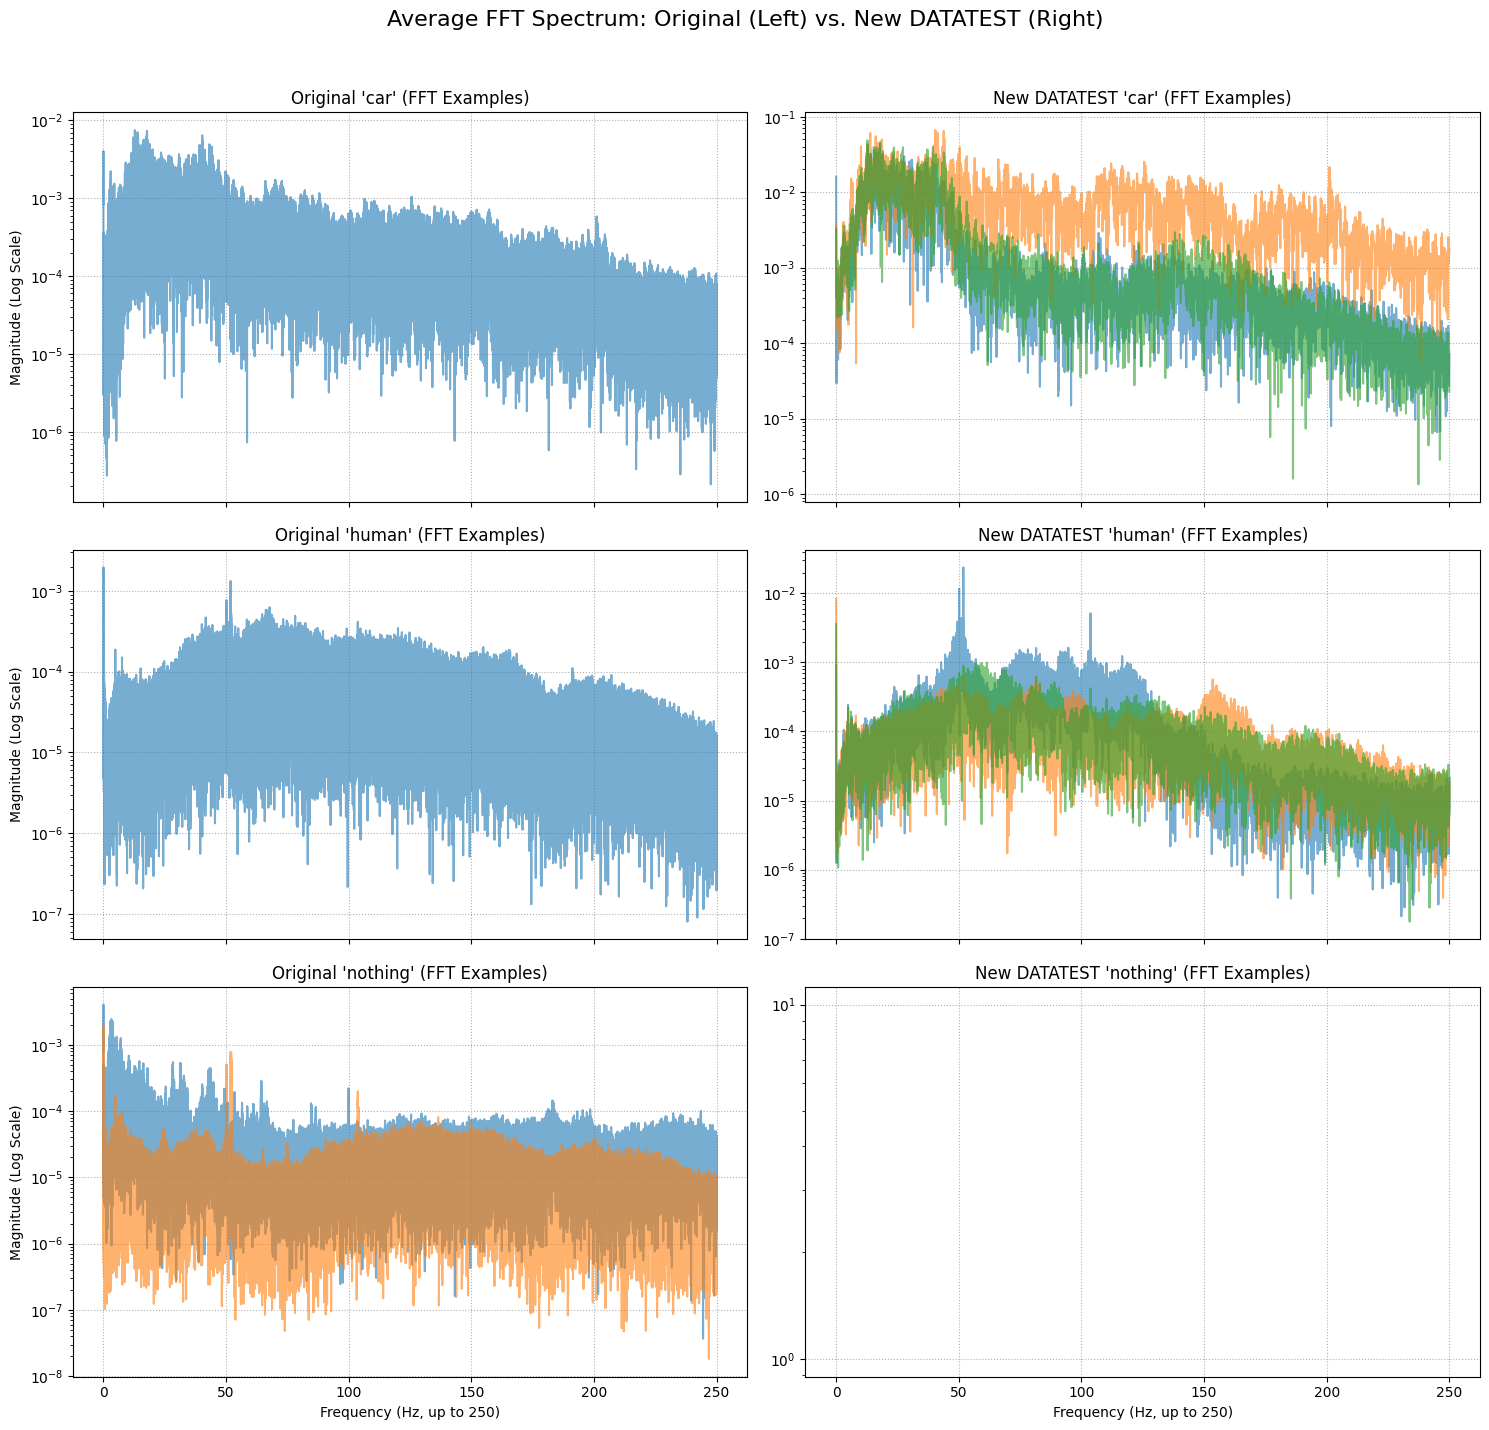


Comparison 4: Number of Generated Windows per Category...


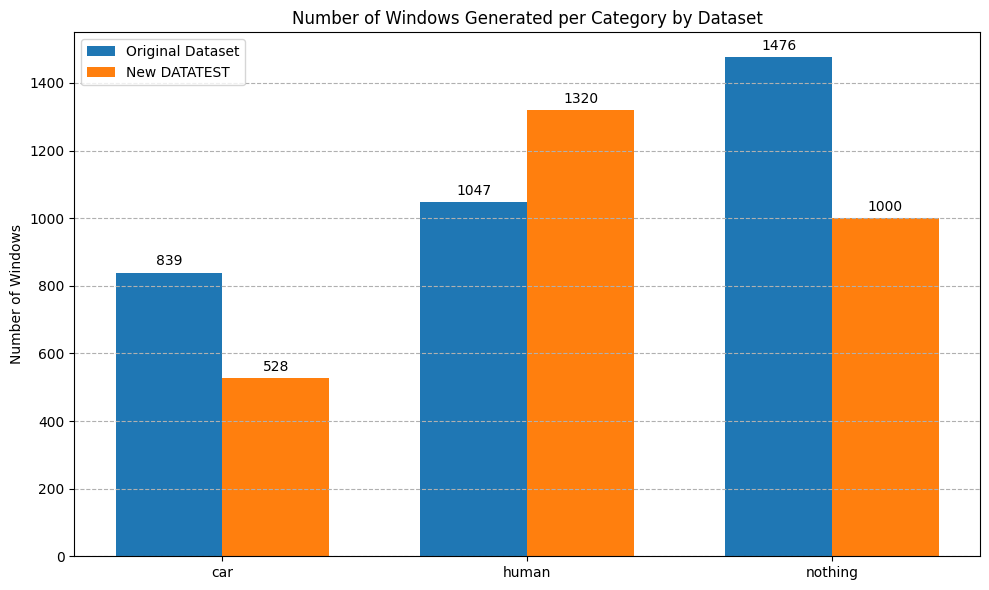


--- Dataset Comparison Complete ---


In [83]:
# Part 7: Dataset Comparison (Original vs. External DATATEST)

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe, skew, kurtosis # For more detailed stats
import numpy.fft as fft # For spectral analysis
import random

print("\n--- Part 7: Dataset Comparison ---")

# --- Configuration ---
ORIGINAL_DATA_DIR = 'DATA' # Or wherever your original CSVs are
DATATEST_DIR = 'DATATEST'
ORIGINAL_CATEGORIES = ['car', 'human', 'nothing'] # Verify order matches original training
# Mapping for the new dataset folders
NEW_FOLDER_MAPPING = {
    'car': 'car',
    'man': 'human',
    'other': 'nothing'
}
NUM_SIGNALS_TO_PLOT = 3   # How many examples to plot per category
NUM_SIGNALS_FOR_STATS = 50 # How many signals per category for stats/FFT (or None for all)
FFT_PLOT_MAX_FREQ = 250 # Max frequency to show in FFT plots (adjust based on interest)
SAMPLE_RATE = 1000 # Hz (Assuming this is still correct)
# --------------------

# --- Helper Functions ---

# Function to load raw series data (similar to Part 1 but simpler)
def load_raw_series(data_dir, category_mapping=None):
    """Loads raw series, mapping folder names if provided."""
    series_dict = {cat: [] for cat in ORIGINAL_CATEGORIES}
    print(f"Loading raw data from: {data_dir}")
    folders_to_scan = category_mapping.keys() if category_mapping else os.listdir(data_dir)

    for folder_name in folders_to_scan:
        original_category = category_mapping.get(folder_name) if category_mapping else folder_name
        if original_category not in ORIGINAL_CATEGORIES:
            # print(f"  Skipping folder '{folder_name}' (not in ORIGINAL_CATEGORIES or mapping)")
            continue

        folder_path = os.path.join(data_dir, folder_name)
        if not os.path.isdir(folder_path):
            # print(f"  Skipping '{folder_path}' (not a directory)")
            continue

        print(f"  Processing folder '{folder_name}' -> category '{original_category}'")
        csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
        if not csv_files:
            print(f"    Warning: No CSVs found.")
            continue

        for filepath in csv_files:
            try:
                df = pd.read_csv(filepath, header=None)
                for i, col_name in enumerate(df.columns):
                    series_dict[original_category].append(df[col_name].values)
            except Exception as e:
                print(f"    Error processing file {os.path.basename(filepath)}: {e}")

    # Remove categories with no loaded data
    series_dict = {k: v for k, v in series_dict.items() if v}
    print("Raw data loading complete.")
    return series_dict

# Function to calculate basic stats for a list of signals
def calculate_stats(signals):
    stats = {
        'mean': [], 'std': [], 'min': [], 'max': [], 'rms': [], 'length': [],
        'skewness': [], 'kurtosis': []
    }
    if not signals: return {key: 0 for key in stats}, {key: 0 for key in stats} # Return zeros if empty

    for s in signals:
        if len(s) == 0: continue # Skip empty signals
        stats['mean'].append(np.mean(s))
        stats['std'].append(np.std(s))
        stats['min'].append(np.min(s))
        stats['max'].append(np.max(s))
        stats['rms'].append(np.sqrt(np.mean(s**2))) # Root Mean Square
        stats['length'].append(len(s))
        # Use scipy.stats.describe for skewness and kurtosis, handle potential errors
        try:
             desc = describe(s)
             stats['skewness'].append(desc.skewness)
             stats['kurtosis'].append(desc.kurtosis) # Fisher's kurtosis (normal=0)
        except: # Handle cases like constant signals where stats might fail
             stats['skewness'].append(np.nan)
             stats['kurtosis'].append(np.nan)


    # Calculate average and std dev of the stats across signals
    avg_stats = {key: np.nanmean(values) if values else 0 for key, values in stats.items()}
    std_stats = {key: np.nanstd(values) if values else 0 for key, values in stats.items()}

    return avg_stats, std_stats

# Function to calculate FFT magnitude spectrum
def calculate_fft_spectrum(signal, sample_rate):
    if len(signal) == 0: return np.array([]), np.array([])
    N = len(signal)
    yf = fft.fft(signal)
    xf = fft.fftfreq(N, 1 / sample_rate)
    # Return only positive frequencies and corresponding magnitude
    mask = xf >= 0
    return xf[mask], np.abs(yf[mask]) / N # Normalize magnitude


# --- Main Comparison Logic ---
if __name__ == '__main__':

    print("Starting Dataset Comparison...")

    # --- 1. Load Data ---
    # Load original data (reuse if available, otherwise load)
    if 'all_series' in locals() and 'all_labels' in locals() and len(all_series) > 0:
        print("Using pre-loaded original data (all_series, all_labels).")
        # Reorganize into dictionary by category name if needed
        original_data_dict = {cat: [] for cat in ORIGINAL_CATEGORIES}
        original_label_names = label_encoder.inverse_transform(encoded_labels) if 'label_encoder' in locals() else all_labels
        for i, series in enumerate(all_series):
            label_name = original_label_names[i]
            if label_name in original_data_dict:
                original_data_dict[label_name].append(series)
        print("Organized original data by category.")
    else:
        print("Loading original data from scratch...")
        # Assuming original data was flat or needs mapping from filename like DATATEST
        # This part might need adjustment based on how original data was structured/loaded initially
        # Let's assume it was loaded flat, and we need the mapping like in Part 1
        original_data_dict = load_raw_series(ORIGINAL_DATA_DIR) # Load without specific mapping, relies on file names

    # Load new external data
    new_data_dict = load_raw_series(DATATEST_DIR, category_mapping=NEW_FOLDER_MAPPING)

    if not original_data_dict or not new_data_dict:
        print("\nERROR: Could not load data from both original and new directories. Cannot compare.")
        exit()

    print("\nData Loading Summary:")
    print("  Original Dataset:")
    for cat, signals in original_data_dict.items(): print(f"    {cat}: {len(signals)} signals")
    print("  New DATATEST Dataset:")
    for cat, signals in new_data_dict.items(): print(f"    {cat}: {len(signals)} signals")


    # --- 2. Visual Comparison: Raw Signals ---
    print("\nComparison 1: Plotting Raw Signal Examples...")
    num_cats = len(ORIGINAL_CATEGORIES)
    fig_raw, axes_raw = plt.subplots(num_cats, 2, figsize=(15, 5 * num_cats), sharex=False, sharey=False)
    fig_raw.suptitle('Raw Signal Examples: Original (Left) vs. New DATATEST (Right)', fontsize=16)

    for i, category in enumerate(ORIGINAL_CATEGORIES):
        # Original Data Plot
        ax_orig = axes_raw[i, 0]
        if category in original_data_dict and original_data_dict[category]:
            signals_orig = random.sample(original_data_dict[category], min(NUM_SIGNALS_TO_PLOT, len(original_data_dict[category])))
            for sig in signals_orig:
                 ax_orig.plot(sig, alpha=0.7)
            ax_orig.set_title(f"Original '{category}' ({len(signals_orig)} examples)")
            ax_orig.set_ylabel("Amplitude")
            ax_orig.grid(True, linestyle=':')
        else:
            ax_orig.set_title(f"Original '{category}' (No Data)")
            ax_orig.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax_orig.transAxes)


        # New Data Plot
        ax_new = axes_raw[i, 1]
        if category in new_data_dict and new_data_dict[category]:
             signals_new = random.sample(new_data_dict[category], min(NUM_SIGNALS_TO_PLOT, len(new_data_dict[category])))
             for sig in signals_new:
                  ax_new.plot(sig, alpha=0.7)
             ax_new.set_title(f"New DATATEST '{category}' ({len(signals_new)} examples)")
             ax_new.grid(True, linestyle=':')
        else:
             ax_new.set_title(f"New DATATEST '{category}' (No Data)")
             ax_new.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax_new.transAxes)

        if i == num_cats - 1: # Add x-label only to bottom plots
            ax_orig.set_xlabel("Samples")
            ax_new.set_xlabel("Samples")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


    # --- 3. Statistical Comparison ---
    print("\nComparison 2: Statistical Properties (Averages per Category)...")
    print("-" * 60)
    print(f"{'Category':<10} | {'Dataset':<10} | {'Mean':<10} | {'Std Dev':<10} | {'RMS':<10} | {'Min':<10} | {'Max':<10} | {'Skew':<10} | {'Kurtosis':<10} | Samples")
    print("-" * 60)

    for category in ORIGINAL_CATEGORIES:
        # Original Stats
        if category in original_data_dict and original_data_dict[category]:
            signals_orig = original_data_dict[category]
            if NUM_SIGNALS_FOR_STATS and len(signals_orig) > NUM_SIGNALS_FOR_STATS:
                 signals_orig = random.sample(signals_orig, NUM_SIGNALS_FOR_STATS)
            avg_stats_orig, _ = calculate_stats(signals_orig)
            print(f"{category:<10} | {'Original':<10} | {avg_stats_orig['mean']:.2e} | {avg_stats_orig['std']:.2e} | {avg_stats_orig['rms']:.2e} | {avg_stats_orig['min']:.2e} | {avg_stats_orig['max']:.2e} | {avg_stats_orig['skewness']:.2f}   | {avg_stats_orig['kurtosis']:.2f}    | {len(signals_orig)}")
        else:
             print(f"{category:<10} | {'Original':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | 0")


        # New Stats
        if category in new_data_dict and new_data_dict[category]:
            signals_new = new_data_dict[category]
            if NUM_SIGNALS_FOR_STATS and len(signals_new) > NUM_SIGNALS_FOR_STATS:
                 signals_new = random.sample(signals_new, NUM_SIGNALS_FOR_STATS)
            avg_stats_new, _ = calculate_stats(signals_new)
            print(f"{category:<10} | {'New Test':<10} | {avg_stats_new['mean']:.2e} | {avg_stats_new['std']:.2e} | {avg_stats_new['rms']:.2e} | {avg_stats_new['min']:.2e} | {avg_stats_new['max']:.2e} | {avg_stats_new['skewness']:.2f}   | {avg_stats_new['kurtosis']:.2f}    | {len(signals_new)}")
        else:
            print(f"{category:<10} | {'New Test':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10} | 0")
        print("-" * 60)


    # --- 4. Spectral Comparison (FFT) ---
    print("\nComparison 3: Spectral Analysis (FFT Magnitude)...")
    fig_fft, axes_fft = plt.subplots(num_cats, 2, figsize=(15, 5 * num_cats), sharex=True, sharey=False)
    fig_fft.suptitle('Average FFT Spectrum: Original (Left) vs. New DATATEST (Right)', fontsize=16)

    for i, category in enumerate(ORIGINAL_CATEGORIES):
        # Original FFT
        ax_orig_fft = axes_fft[i, 0]
        if category in original_data_dict and original_data_dict[category]:
            signals_orig = original_data_dict[category]
            if NUM_SIGNALS_FOR_STATS and len(signals_orig) > NUM_SIGNALS_FOR_STATS:
                signals_orig = random.sample(signals_orig, NUM_SIGNALS_FOR_STATS)

            all_freqs_orig, all_mags_orig = [], []
            max_len_orig = 0
            for sig in signals_orig: max_len_orig = max(max_len_orig, len(sig)) # Find max length for averaging

            # Calculate FFT for each signal and store
            processed_fft_count_orig = 0
            for sig in signals_orig:
                 if len(sig) == 0: continue
                 freqs, mags = calculate_fft_spectrum(sig, SAMPLE_RATE)
                 if freqs.size > 0:
                     all_freqs_orig.append(freqs)
                     all_mags_orig.append(mags)
                     processed_fft_count_orig += 1

            # Average FFT magnitudes (simple approach: average signals with same length, or interpolate - complex)
            # Let's just plot the first few FFTs for simplicity here
            if processed_fft_count_orig > 0:
                for k in range(min(processed_fft_count_orig, NUM_SIGNALS_TO_PLOT)): # Plot a few examples
                    mask = all_freqs_orig[k] <= FFT_PLOT_MAX_FREQ
                    ax_orig_fft.semilogy(all_freqs_orig[k][mask], all_mags_orig[k][mask], alpha=0.6) # Log scale for magnitude
                ax_orig_fft.set_title(f"Original '{category}' (FFT Examples)")
                ax_orig_fft.set_ylabel("Magnitude (Log Scale)")
                ax_orig_fft.grid(True, linestyle=':')
            else:
                 ax_orig_fft.set_title(f"Original '{category}' (No FFT Data)")

        else:
            ax_orig_fft.set_title(f"Original '{category}' (No Data)")

        # New FFT
        ax_new_fft = axes_fft[i, 1]
        if category in new_data_dict and new_data_dict[category]:
            signals_new = new_data_dict[category]
            if NUM_SIGNALS_FOR_STATS and len(signals_new) > NUM_SIGNALS_FOR_STATS:
                signals_new = random.sample(signals_new, NUM_SIGNALS_FOR_STATS)

            all_freqs_new, all_mags_new = [], []
            processed_fft_count_new = 0
            for sig in signals_new:
                if len(sig) == 0: continue
                freqs, mags = calculate_fft_spectrum(sig, SAMPLE_RATE)
                if freqs.size > 0:
                    all_freqs_new.append(freqs)
                    all_mags_new.append(mags)
                    processed_fft_count_new +=1

            if processed_fft_count_new > 0:
                for k in range(min(processed_fft_count_new, NUM_SIGNALS_TO_PLOT)):
                    mask = all_freqs_new[k] <= FFT_PLOT_MAX_FREQ
                    ax_new_fft.semilogy(all_freqs_new[k][mask], all_mags_new[k][mask], alpha=0.6)
                ax_new_fft.set_title(f"New DATATEST '{category}' (FFT Examples)")
                ax_new_fft.grid(True, linestyle=':')
            else:
                ax_new_fft.set_title(f"New DATATEST '{category}' (No FFT Data)")
        else:
            ax_new_fft.set_title(f"New DATATEST '{category}' (No Data)")

        if i == num_cats - 1: # Add x-label only to bottom plots
            ax_orig_fft.set_xlabel(f"Frequency (Hz, up to {FFT_PLOT_MAX_FREQ})")
            ax_new_fft.set_xlabel(f"Frequency (Hz, up to {FFT_PLOT_MAX_FREQ})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # --- 5. Window Count Comparison ---
    print("\nComparison 4: Number of Generated Windows per Category...")
    # Need windowing parameters
    if 'WINDOW_SIZE' in locals() and 'STEP' in locals():
        orig_window_counts = {}
        for cat, signals in original_data_dict.items():
            count = 0
            for sig in signals: count += len(create_windows(sig, WINDOW_SIZE, STEP))
            orig_window_counts[cat] = count

        new_window_counts = {}
        for cat, signals in new_data_dict.items():
            count = 0
            for sig in signals: count += len(create_windows(sig, WINDOW_SIZE, STEP))
            new_window_counts[cat] = count

        # Prepare data for plotting
        plot_labels = ORIGINAL_CATEGORIES
        orig_counts = [orig_window_counts.get(cat, 0) for cat in plot_labels]
        new_counts = [new_window_counts.get(cat, 0) for cat in plot_labels]

        x = np.arange(len(plot_labels))
        width = 0.35

        fig_counts, ax_counts = plt.subplots(figsize=(10, 6))
        rects1 = ax_counts.bar(x - width/2, orig_counts, width, label='Original Dataset')
        rects2 = ax_counts.bar(x + width/2, new_counts, width, label='New DATATEST')

        ax_counts.set_ylabel('Number of Windows')
        ax_counts.set_title('Number of Windows Generated per Category by Dataset')
        ax_counts.set_xticks(x)
        ax_counts.set_xticklabels(plot_labels)
        ax_counts.legend()
        ax_counts.bar_label(rects1, padding=3)
        ax_counts.bar_label(rects2, padding=3)
        plt.grid(axis='y', linestyle='--')
        fig_counts.tight_layout()
        plt.show()

    else:
        print("Skipping window count comparison (WINDOW_SIZE or STEP not defined).")

    print("\n--- Dataset Comparison Complete ---")

else:
    print("This script should be run directly.")